In [5]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [6]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.11.0
pandas==1.1.4
numpy==1.18.5
matplotlib==3.3.3


In [7]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

TSLA Time Period: **Mar 23, 2018 - Mar 23, 2019**

In [8]:
df = pd.read_csv('../dataset/GOOG2020.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-01,1265.000000,1274.619995,1260.500000,1273.739990,1273.739990,1670100
1,2019-11-04,1276.449951,1294.130005,1276.354980,1291.369995,1291.369995,1501000
2,2019-11-05,1292.890015,1298.930054,1291.229004,1292.030029,1292.030029,1282700
3,2019-11-06,1289.459961,1293.729980,1282.500000,1291.800049,1291.800049,1152700
4,2019-11-07,1294.280029,1323.739990,1294.244995,1308.859985,1308.859985,2030000


In [9]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
l = len(close) - 1

In [10]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [11]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [12]:
model = Model(window_size, 500, 3)
agent = Agent(model, 10000, 5, 5)
agent.fit(500, 10)

iter 10. reward: 41.577696
iter 20. reward: 59.104711
iter 30. reward: 91.265601
iter 40. reward: 89.901100
iter 50. reward: 107.288198
iter 60. reward: 113.047108
iter 70. reward: 109.930204
iter 80. reward: 121.207704
iter 90. reward: 135.883909
iter 100. reward: 126.964497
iter 110. reward: 137.242509
iter 120. reward: 150.356084
iter 130. reward: 130.024194
iter 140. reward: 145.715084
iter 150. reward: 136.996290
iter 160. reward: 146.361089
iter 170. reward: 154.458088
iter 180. reward: 148.865191
iter 190. reward: 146.670184
iter 200. reward: 151.127389
iter 210. reward: 153.553179
iter 220. reward: 147.977472
iter 230. reward: 154.270474
iter 240. reward: 171.839774
iter 250. reward: 171.795665
iter 260. reward: 154.782775
iter 270. reward: 162.368154
iter 280. reward: 180.184852
iter 290. reward: 173.944869
iter 300. reward: 181.300167
iter 310. reward: 189.095962
iter 320. reward: 189.520667
iter 330. reward: 187.828268
iter 340. reward: 199.373062
iter 350. reward: 196.99326

day 0: buy 5 units at price 6368.699950, total balance 3631.300050
day 1, sell 5 units at price 6456.849975, investment 1.384113 %, total balance 10088.150025,
day 3: buy 5 units at price 6459.000245, total balance 3629.149780
day 4, sell 5 units at price 6544.299925, investment 1.320633 %, total balance 10173.449705,
day 5: buy 5 units at price 6556.849975, total balance 3616.599730
day 6: buy 5 units at price 6495.949705, total balance -2879.349975
day 7, sell 5 units at price 6494.000245, investment -0.958535 %, total balance 3614.650270,
day 9, sell 5 units at price 6557.299805, investment 0.944436 %, total balance 10171.950075,
day 10: buy 1 units at price 1334.869995, total balance 8837.080080
day 11: buy 5 units at price 6603.499755, total balance 2233.580325
day 12, sell 5 units at price 6577.299805, investment 392.729616 %, total balance 8810.880130,
day 13: buy 5 units at price 6515.250245, total balance 2295.629885
day 14, sell 5 units at price 6506.749880, investment -1.465

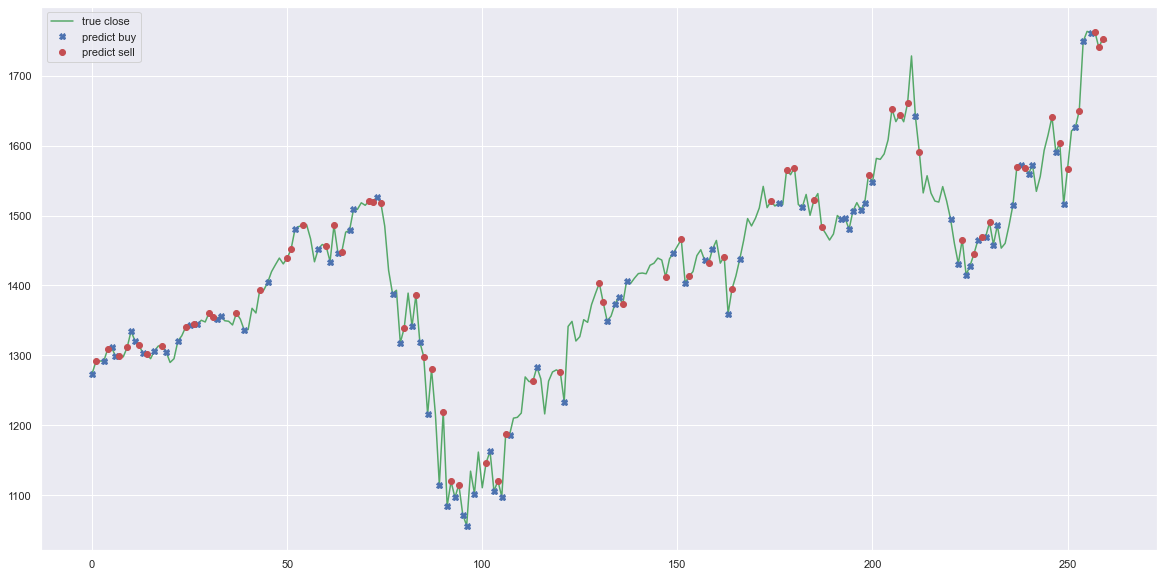

In [13]:
agent.buy()